<a href="https://colab.research.google.com/github/emanueleiacca/ADM-HW4/blob/main/DataPreparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 4 - Movie Recommendation System**

### #Group21
Camilla Labbate - camillalabbate02@icloud.com

Emanuele Iaccarino - emanueleiaccarino.ei@gmail.com

Andrej Sterjev - andrej.sterjev@gmail.com

## 1. **Recommendation System with LSH**

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
#movielens_20m_dataset_path = kagglehub.dataset_download('grouplens/movielens-20m-dataset')
print('Data source import complete.')


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


https://github.com/rapidsai/cudf?tab=readme-ov-file#pip

In [4]:
pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [106]:
import rmm
import cudf
rmm.reinitialize(pool_allocator=True, managed_memory=True)
print("RAPIDS cuDF is using GPU memory:", rmm.is_initialized())

RAPIDS cuDF is using GPU memory: True


In [6]:
import cupy as cp

def check_memory():
    memory_pool = cp.get_default_memory_pool()
    total_memory = cp.cuda.Device(0).mem_info[0]  # Total memory available
    used_memory = memory_pool.used_bytes()       # Memory allocated by the pool
    free_memory = total_memory - used_memory
    print(f"GPU Memory - Total: {total_memory / (1024**3):.2f} GB, Used: {used_memory / (1024**3):.2f} GB, Free: {free_memory / (1024**3):.2f} GB")

check_memory()

GPU Memory - Total: 14.65 GB, Used: 0.00 GB, Free: 14.65 GB


In [7]:
movielens_20m_dataset_path = kagglehub.dataset_download('grouplens/movielens-20m-dataset')


dataset_directory = '/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1'

for dirname, _, filenames in os.walk(dataset_directory):
    for filename in filenames:
        print(f"File trovato: {filename}")

100%|██████████| 195M/195M [00:04<00:00, 49.1MB/s]

Extracting files...


File trovato: movie.csv
File trovato: genome_tags.csv
File trovato: tag.csv
File trovato: link.csv
File trovato: genome_scores.csv
File trovato: rating.csv


In [107]:
ratings_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/rating.csv")
links_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/link.csv")
genome_tags_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_tags.csv")
genome_scores_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_scores.csv")
tags_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/tag.csv")
movies_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/movie.csv")


In [ ]:
check_memory()

GPU Memory - Total: 12.14 GB, Used: 0.00 GB, Free: 12.14 GB


In [ ]:
print("ratings_df:",ratings_df.columns)
print("links_df:",links_df.columns)
print("genome_tags_df:",genome_tags_df.columns)
print("genome_scores_df:",genome_scores_df.columns)
print("tags_df:",tags_df.columns)
print("movies_df:",movies_df.columns)

ratings_df: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
links_df: Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')
genome_tags_df: Index(['tagId', 'tag'], dtype='object')
genome_scores_df: Index(['movieId', 'tagId', 'relevance'], dtype='object')
tags_df: Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')
movies_df: Index(['movieId', 'title', 'genres'], dtype='object')


In [ ]:
import gc
rmm.reinitialize(pool_allocator=True, managed_memory=True)  # Reset GPU memory
movies_links = movies_df.merge(links_df, on="movieId", how="left")
del links_df  # Free up memory
gc.collect()
movies_links.head()

,movieId,title,genres,imdbId,tmdbId
0,4110,"Fourth Protocol, The (1987)",Thriller,93044,4918
1,4111,Gardens of Stone (1987),Drama|War,93073,28368
2,4112,Julia and Julia (Giulia e Giulia) (1987),Drama|Mystery|Thriller,93092,58084
3,4113,"Glass Menagerie, The (1987)",Drama,93093,52780
4,4114,"Good Morning, Babylon (1987)",Drama,93104,48149


In [ ]:
# Merge ratings with movies
rmm.reinitialize(pool_allocator=True, managed_memory=True)  # Reset GPU memory
ratings_movies = ratings_df.merge(movies_links, on="movieId", how="left")
del ratings_df, movies_links  # Free up memory
gc.collect()
ratings_movies.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId
0,91,165,3.5,2005-07-18 07:58:38,Die Hard: With a Vengeance (1995),Action|Crime|Thriller,112864,1572
1,91,168,2.5,2005-09-12 06:49:36,First Knight (1995),Action|Drama|Romance,113071,6520
2,91,172,2.5,2005-09-12 06:48:40,Johnny Mnemonic (1995),Action|Sci-Fi|Thriller,113481,9886
3,91,173,3.0,2005-07-18 08:13:32,Judge Dredd (1995),Action|Crime|Sci-Fi,113492,9482
4,91,185,2.5,2005-07-18 08:00:21,"Net, The (1995)",Action|Crime|Thriller,113957,1642


In [ ]:
rmm.reinitialize(pool_allocator=True, managed_memory=True)  # Reset GPU memory
# Merge genome scores with genome tags
genome_data = genome_scores_df.merge(genome_tags_df, on="tagId", how="left")
del genome_tags_df  # Free up memory
gc.collect()
genome_data.head()

,movieId,tagId,relevance,tag
0,1,65,0.10100,anime
1,1,66,0.03750,antarctica
2,1,67,0.12075,anti-hero
3,1,68,0.03775,anti-semitism
4,1,69,0.02000,anti-war


In [ ]:
rmm.reinitialize(pool_allocator=True, managed_memory=True)
# Merge tags with movies
tags_movies = tags_df.merge(movies_df, on="movieId", how="left")
del tags_df  # Free up memory
gc.collect()
tags_movies.head()

,userId,movieId,tag,timestamp,title,genres
0,964,1197,fairy tale,2010-10-09 17:10:13,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
1,964,1197,fantasy,2010-10-09 17:10:14,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
2,964,1197,funny,2010-10-09 17:10:18,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
3,964,1197,good versus evil,2010-10-09 17:10:20,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
4,964,1197,imdb top 250,2010-10-09 17:10:16,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance


In [ ]:
check_memory()

GPU Memory - Total: 9.64 GB, Used: 0.00 GB, Free: 9.64 GB


In [ ]:
print("ratings_movies:",ratings_movies.columns)
print("genome_data:",genome_data.columns)
print("tags_movies:",tags_movies.columns)

ratings_movies: Index(['userId', 'movieId', 'rating', 'title', 'genres', 'timestamp'], dtype='object')
genome_data: Index(['movieId', 'tagId', 'relevance', 'tag'], dtype='object')
tags_movies: Index(['userId', 'movieId', 'tag', 'timestamp', 'title', 'genres'], dtype='object')


In [ ]:
ratings_movies = ratings_movies[["userId", "movieId", "rating", "title", "genres","timestamp"]]
genome_data = genome_data[["movieId", "tag", "relevance"]]
tags_movies = tags_movies[["userId", "movieId", "tag"]]
#Remove repeated columns

In [ ]:
print("ratings_movies:",ratings_movies.info())
print("genome_data:",genome_data.info())
print("tags_movies:",tags_movies.info())

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column     Dtype
---  ------     -----
 0   userId     int64
 1   movieId    int64
 2   rating     float64
 3   title      object
 4   genres     object
 5   timestamp  object
dtypes: float64(1), int64(2), object(3)
memory usage: 1.8+ GB
ratings_movies: None
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
 #   Column     Dtype
---  ------     -----
 0   movieId    int64
 1   tag        object
 2   relevance  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 335.2+ MB
genome_data: None
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 465426 entries, 0 to 465425
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   userId   465426 non-null  int64
 1   movieId  465426 non-null  int64
 2   tag      465426 non-null  object
dtypes: int

### 1.1 Data Preparation

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score


In [108]:
movies_df_pd = movies_df.to_pandas()
rating_df_pd=ratings_df.to_pandas()
tags_df_pd=tags_df.to_pandas()
genome_tags_df_pd=genome_tags_df.to_pandas()
genome_scores_df_pd=genome_scores_df.to_pandas()
links_df_pd=links_df.to_pandas()

In [11]:
print("\nInfo about dataset 'movies':")
print(movies_df_pd.info())

print("\nInfo about dataset 'ratings':")
print(rating_df_pd.info())


print("\nInfo about dataset 'tag':")
print(tags_df_pd.info())

print("\nInfo about dataset 'genome_tags':")
print(genome_tags_df_pd.info())


print("\nInfo about dataset  'genome_scores':")
print(genome_scores_df_pd.info())

print("\nInfo about dataset 'link':")
print(links_df_pd.info())

display(movies_df_pd.head())
display(rating_df_pd.head())
display(tags_df_pd.head())
display(genome_tags_df_pd.head())
display(genome_scores_df_pd.head())
display(links_df_pd.head())


Info about dataset 'movies':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB
None

Info about dataset 'ratings':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB
None

Info about dataset 'tag':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465426 entries, 0 to 465425
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     465426 non-null  int64 
 1   

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [12]:
print(rating_df_pd.isnull().sum())
print(movies_df_pd.isnull().sum())
print(tags_df_pd.isnull().sum())
print(links_df_pd.isnull().sum())
print(genome_scores_df_pd.isnull().sum())
print(genome_tags_df_pd.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64
movieId      0
imdbId       0
tmdbId     252
dtype: int64
movieId      0
tagId        0
relevance    0
dtype: int64
tagId    0
tag      0
dtype: int64


In [13]:
rating_df=rating_df_pd.drop_duplicates()
movies_df=movies_df_pd.drop_duplicates()
tags_df=tags_df_pd.drop_duplicates()
links_df=links_df_pd.drop_duplicates()
genome_scores_df=genome_scores_df_pd.drop_duplicates()
genome_tags_df=genome_tags_df_pd.drop_duplicates()


In [14]:
print("\nexploring dataset 'ratings':")
print(rating_df_pd.describe())

print("\nexploring dataset'movies':")
print(movies_df_pd.describe(include='all'))

print("\nexploring dataset 'link':")
print(links_df_pd.describe())

print("\nexploring dataset'tag':")
print(tags_df_pd.describe(include='all'))

print("\nexploring dataset 'genome_scores':")
print(genome_scores_df_pd.describe())

print("\nexploring dataset'genome_tags':")
print(genome_tags_df_pd.describe(include='all'))


exploring dataset 'ratings':
             userId       movieId        rating
count  2.000026e+07  2.000026e+07  2.000026e+07
mean   6.904587e+04  9.041567e+03  3.525529e+00
std    4.003863e+04  1.978948e+04  1.051989e+00
min    1.000000e+00  1.000000e+00  5.000000e-01
25%    3.439500e+04  9.020000e+02  3.000000e+00
50%    6.914100e+04  2.167000e+03  3.500000e+00
75%    1.036370e+05  4.770000e+03  4.000000e+00
max    1.384930e+05  1.312620e+05  5.000000e+00

exploring dataset'movies':
              movieId           title genres
count    27278.000000           27278  27278
unique            NaN           27262   1342
top               NaN  Aladdin (1992)  Drama
freq              NaN               2   4520
mean     59855.480570             NaN    NaN
std      44429.314697             NaN    NaN
min          1.000000             NaN    NaN
25%       6931.250000             NaN    NaN
50%      68068.000000             NaN    NaN
75%     100293.250000             NaN    NaN
max     131262.

In [15]:
movies_df_pd['genres'] = movies_df_pd['genres'].str.replace('|', ' ')
tfidf = TfidfVectorizer(stop_words='english')


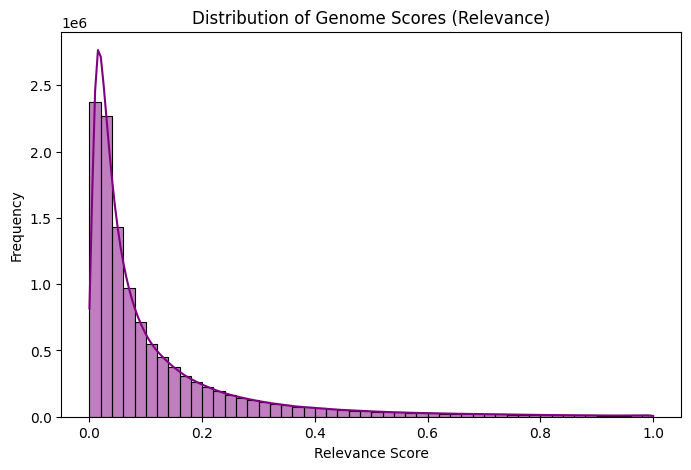

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(genome_scores_df_pd['relevance'], bins=50, kde=True, color='purple')
plt.title('Distribution of Genome Scores (Relevance)')
plt.xlabel('Relevance Score')
plt.ylabel('Frequency')
plt.show()

There are noticeable peaks around ratings like 3.0, 4.0, and 5.0, suggesting that many users tend to give these scores.
Ratings below 2.0 are much less frequent.
The dataset might have a tendency towards higher ratings, indicating a positive skew (more ratings closer to 4 or 5).

This distribution suggests that users tend to rate movies positively, with most ratings clustering around 3 to 5. This behavior is common in user-generated rating datasets, where extreme negative ratings are less frequent.

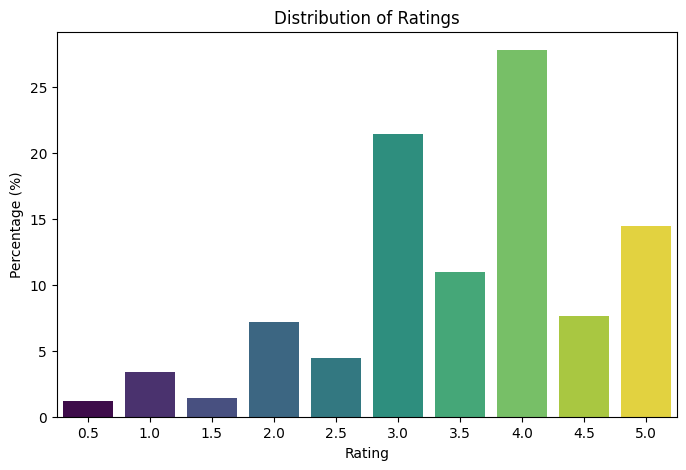

In [17]:
rating_counts = rating_df_pd['rating'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(
    x=rating_counts.index,
    y=(rating_counts.values / rating_counts.sum()) * 100,
    hue=rating_counts.index,
    palette='viridis',
    legend=False
)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Percentage (%)')
plt.show()


This bar chart shows the distribution of ratings as percentages. The X-axis represents the rating values while the Y-axis shows the percentage of ratings for each value.

The  bar chart shows  the distribution of ratings given by users. The X-axis represents rating values (from 0.5 to 5.0), while the Y-axis shows the percentage of users who gave a specific rating.


1. **Higher ratings (4.0 - 5.0) dominate:** Most users gave high ratings like 4.0 and 5.0, represented by green and yellow bars, suggesting users tend to rate positively.
2. **Low ratings are rare:** Lower ratings (0.5 - 1.0) are less frequent, with small purple and blue bars, implying users rarely give very low scores.
3. **Overall higher distribution:** The chart's shape suggests users generally give ratings in the higher range, with a slight tilt toward lower values but no strong concentration.

The dataset shows a general tendency for users to provide favorable ratings, with few negative reviews. This could be typical of a context where reviews are mostly positive, or the ratings are influenced by a large number of maximum scores.

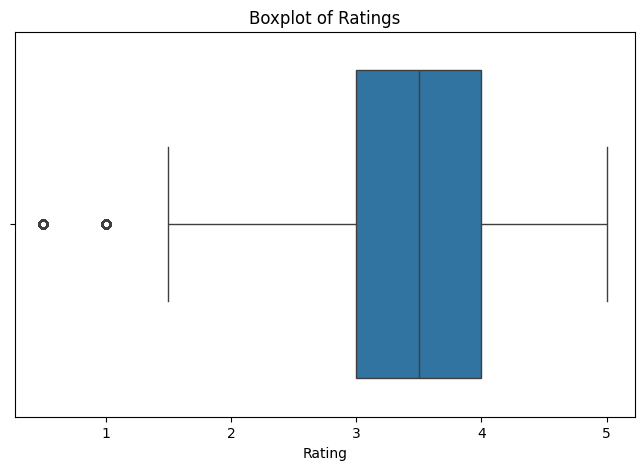

In [18]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=rating_df_pd['rating'])
plt.title('Boxplot of Ratings')
plt.xlabel('Rating')
plt.show()

The box represents the interquartile range (IQR), which contains the middle 50% of the data (from the first quartile Q1 to the third quartile Q3).
The line inside the box represents the median, indicating the middle value of the dataset.
The whiskers extend to the smallest and largest values within 1.5 times the IQR.
Two outliers are visible as individual points outside the whiskers. These are ratings below the lower whisker threshold.
The data seems to show a concentration of ratings between 3 and 4, with a few low outliers around 1.







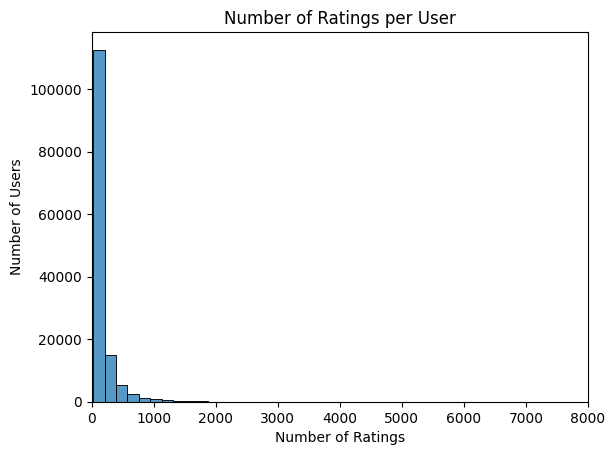

In [ ]:
user_ratings_count = rating_df_pd['userId'].value_counts()
sns.histplot(user_ratings_count, bins=50, kde=False)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.xlim(0, 8000)
plt.show()

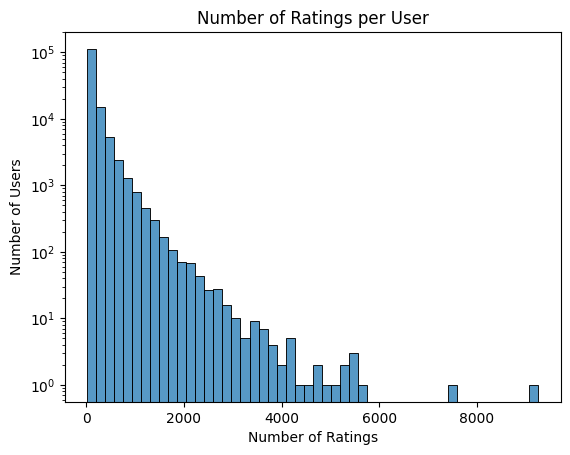

In [ ]:
user_ratings_count = rating_df_pd['userId'].value_counts()
sns.histplot(user_ratings_count, bins=50, kde=False)
plt.yscale('log')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()



- **X-Axis**: "Number of Ratings" — Represents the number of ratings provided by individual users.
- **Y-Axis**: "Number of Users" — Represents the number of users corresponding to a particular number of ratings.
- The Y-axis is plotted on a **logarithmic scale**, as indicated by the uneven spacing of numbers (e.g., \(10^0, 10^1, 10^2, \dots\)).

- The data shows a **right-skewed distribution**.
- Most users have given very few ratings, as shown by the tall bar on the left-hand side of the histogram.
- A small number of users have provided significantly more ratings, as indicated by the sparse bars extending towards higher numbers of ratings (up to around 9000).
- The frequency of users decreases rapidly as the number of ratings increases.

This suggests that the majority of users are less active, while a small subset of users are highly active in providing ratings.

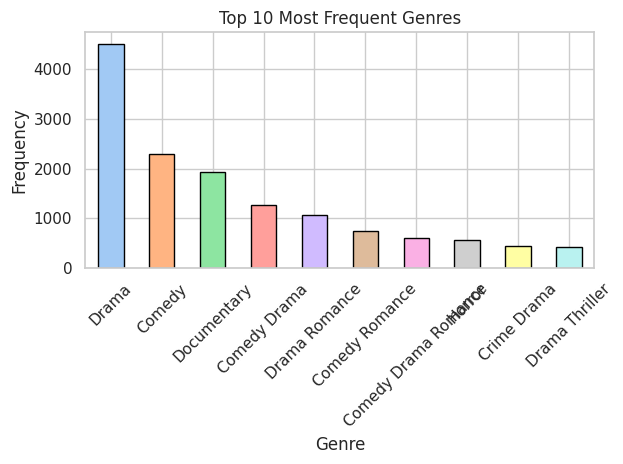

In [ ]:
movies_df_pd['genres'] = movies_df_pd['genres'].dropna().astype(str).str.split('|')

# Flatten the list of genres
all_genres = [genre for sublist in movies_df_pd['genres'] for genre in sublist]

# Count genre occurrences and get the top 10
genre_counts = pd.Series(all_genres).value_counts().head(10)

# Plot with a custom Seaborn palette
sns.set(style="whitegrid")
palette = sns.color_palette("pastel", 10)

# Create the bar chart
genre_counts.plot(kind='bar', color=palette, edgecolor='black')

# Add titles and labels
plt.title('Top 10 Most Frequent Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Show the plot
plt.tight_layout()  # Adjust layout to avoid cutting off labels
plt.show()


- In the chart above, it is possible to observe the 10 most-watched film genres by users on the platform. According to the chart, the most captivating genre is Drama, followed by Comedy and Documentary.
- According to the chart, the most captivating genre is Drama, followed by Comedy and Documentary.

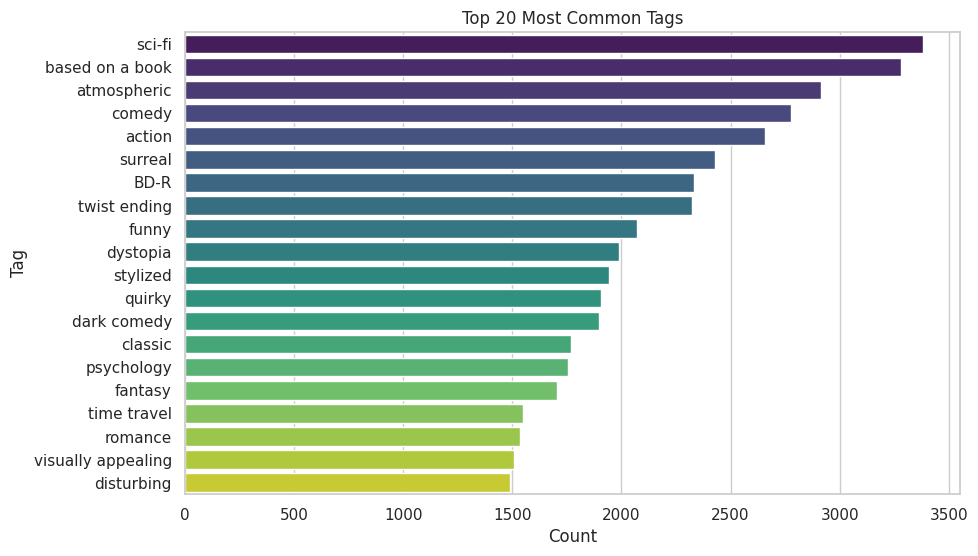

In [ ]:
tag_counts = tags_df_pd['tag'].value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=tag_counts.values, y=tag_counts.index, palette='viridis', hue=tag_counts.index, label=None)  # Set label to None to disable legend
plt.title('Top 20 Most Common Tags')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.show()

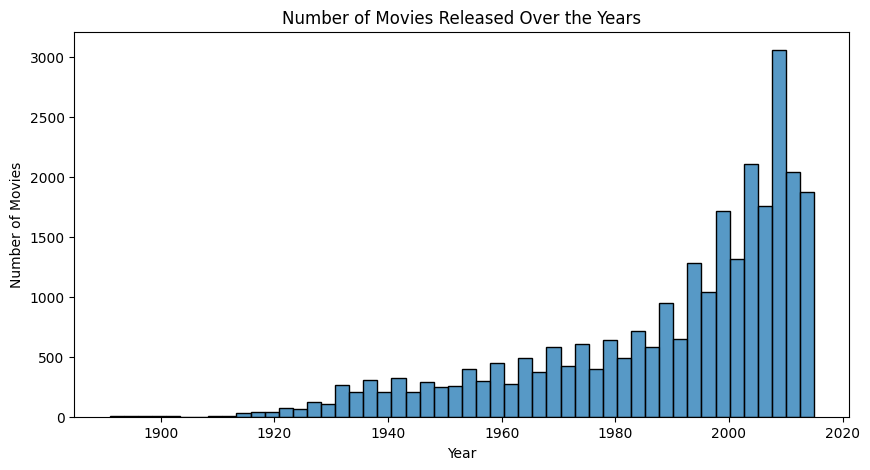

In [ ]:
# Extract release year from the title (assuming format: "Movie Title (Year)")
movies_df_pd['year'] = movies_df_pd['title'].str.extract(r'\((\d{4})\)').astype(float)

# Plot movie releases by year
plt.figure(figsize=(10, 5))
sns.histplot(movies_df_pd['year'].dropna(), bins=50, kde=False)
plt.title('Number of Movies Released Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()


- There is a **steady increase** in the number of movies released over time, particularly after 1960.
- The rate of movie releases accelerates significantly after 1980, with a sharp rise leading up to the early 2000s.
- The highest number of movies released is observed around the early 2000s, peaking just before 2020.
- Earlier years, particularly before 1920, show a minimal number of releases, which gradually increase.

This trend indicates growth in the movie industry, particularly in the latter half of the 20th century, likely due to advancements in technology, increased global demand, and accessibility to filmmaking resources.

## 1.2 Minhash Signatures

In [19]:
user_movies = rating_df_pd.groupby('userId')['movieId'].apply(set).to_dict()

In [20]:
def jaccard_similarity_exact(movies1, movies2):
    intersection = len(movies1 & movies2)
    union = len(movies1 | movies2)
    return intersection / union if union > 0 else 0

In [21]:
def jaccard_similarity_hashed(signature1, signature2):
    matches = sum(1 for x, y in zip(signature1, signature2) if x == y)
    return matches / len(signature1)

In [22]:
def generate_hash_function(a,b,c):
    def hash_function(x):
        return (a * (x%c) + b)
    return hash_function

def generate_hash_functions(num_hashes, max_movie_id, seed=None):

    if seed is not None:
        np.random.seed(seed)
    a = np.random.randint(1, max_movie_id * 2, size=num_hashes)
    b = np.random.randint(0, max_movie_id * 2, size=num_hashes)
    c = max_movie_id * 2 + 1
    return [generate_hash_function(a_, b_, c) for a_, b_ in zip(a, b)]

In [23]:
def create_custom_hash_function(a_coeff, b_coeff, prime_mod):
    """"Defines a cubic hash function based on 2x."""
    def hash_function(input_value):
        return (a_coeff * 2 * input_value + b_coeff) % prime_mod
    return hash_function

def create_hash_function_family(num_functions, max_movie_val, random_seed=None):
    """Generates a series of hash functions using the coefficient 2x in the formula."""
    if random_seed is not None:
        np.random.seed(random_seed)

    a_coefficients = np.random.randint(1, max_movie_val * 2, size=num_functions)
    b_coefficients = np.random.randint(0, max_movie_val * 2, size=num_functions)
    prime_modulo = max_movie_val * 2 + 1

    return [create_custom_hash_function(a, b, prime_modulo) for a, b in zip(a_coefficients, b_coefficients)]

In [24]:
def create_quadratic_hash_function(coeff_a, coeff_b, prime_modulo):
    """"Defines a cubic hash function based on x^2."""
    def hash_function(input_value):
        return (coeff_a * (input_value / 2) + coeff_b * input_value) % prime_modulo
    return hash_function

def create_quadratic_hash_family(num_functions, max_val, random_seed=None):
    """"Generates a series of hash functions using the coefficient x^2 in the formula."."""
    if random_seed is not None:
        np.random.seed(random_seed)

    coeff_a_list = np.random.randint(1, max_val * 2, size=num_functions)
    coeff_b_list = np.random.randint(0, max_val * 2, size=num_functions)
    prime_modulo = max_val * 2 + 1

    return [create_quadratic_hash_function(a, b, prime_modulo) for a, b in zip(coeff_a_list, coeff_b_list)]

In [25]:
def create_cubic_hash_function(coeff_a, coeff_b, prime_mod):
    """"Defines a cubic hash function based on x^3."""
    def hash_function(input_val):
        return (coeff_a * input_val**3 + coeff_b) % prime_mod
    return hash_function

def create_cubic_hash_family(num_functions, max_val, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    a_coeffs = np.random.randint(1, max_val * 2, size=num_functions)
    b_coeffs = np.random.randint(0, max_val * 2, size=num_functions)
    prime_modulo = max_val * 2 + 1

    return [create_cubic_hash_function(a, b, prime_modulo) for a, b in zip(a_coeffs, b_coeffs)]

In [26]:
def generate_signatures(subset_users, user_movie_data, hash_functions):
    """"Create MinHash signatures for a specific group of users."""
    signatures = {}

    for user_id in subset_users:
        watched_movies = user_movie_data.get(user_id, set())

        if not watched_movies:

            signatures[user_id] = [float('inf')] * len(hash_functions)
            continue

        user_signature = []
        for hash_func in hash_functions:

            min_hash_value = min(hash_func(movie) for movie in watched_movies)
            user_signature.append(min_hash_value)

        signatures[user_id] = user_signature

    return signatures

In [27]:
def compute_mse(user_movie_data, signatures, selected_users):
    """Calculate the mean squared error (MSE) between real and estimated similarities for a set of users"""
    total_error = 0
    pair_count = 0

    for idx, user_a in enumerate(selected_users):
        for user_b in selected_users[idx + 1:]:
            # Real similarity based on the Jaccard definition.
            actual_jaccard = jaccard_similarity_hashed(user_movie_data[user_a], user_movie_data[user_b])

            # "Estimated similarity using MinHash signatures."
            estimated_jaccard = jaccard_similarity_hashed(signatures[user_a], signatures[user_b])


            total_error += (actual_jaccard - estimated_jaccard) ** 2
            pair_count += 1

    # Calculate MSE
    return (total_error / pair_count) if pair_count > 0 else 0

In [137]:
# Seleziona tutti gli utenti disponibili
selected_users = list(user_movies.keys())[:100]
selected_user_movies = {user: user_movies[user] for user in selected_users}

# Crea le famiglie di funzioni hash
hash_funcs_2x = create_hash_function_family(
    num_functions=40,
    max_movie_val=int(rating_df['movieId'].max()),  # Converti in int se necessario
    random_seed=42
)

hash_funcs_quadratic = create_quadratic_hash_family(
    num_functions=40,
    max_val=int(rating_df['movieId'].max()),
    random_seed=42
)

hash_funcs_cubic = create_cubic_hash_family(
    num_functions=40,
    max_val=int(rating_df['movieId'].max()),
    random_seed=42
)

# Calcola le firme MinHash per ogni tipo di funzione hash
signatures_2x = {
    user: [int(value) for value in signature]
    for user, signature in generate_signatures(selected_users, selected_user_movies, hash_funcs_2x).items()
}

signatures_quadratic = {
    user: [int(value) for value in signature]
    for user, signature in generate_signatures(selected_users, selected_user_movies, hash_funcs_quadratic).items()
}

signatures_cubic = {
    user: [int(value) for value in signature]
    for user, signature in generate_signatures(selected_users, selected_user_movies, hash_funcs_cubic).items()
}

print("Firme MinHash con hash lineare (2x):", list(signatures_2x.items())[:5])  # Prime 5 firme
print("Firme MinHash con hash quadratico:", list(signatures_quadratic.items())[:5])
print("Firme MinHash con hash cubico:", list(signatures_cubic.items())[:5])

mse_2x = compute_mse(user_movies, signatures_2x, selected_users)
mse_quadratic = compute_mse(user_movies, signatures_quadratic, selected_users)
mse_cubic = compute_mse(user_movies, signatures_cubic, selected_users)

print("MSE 2x:", mse_2x)
print("MSE x^2:", mse_quadratic)
print("MSE x^3:", mse_cubic)


<ipython-input-25-00c844ba0e71>:4: RuntimeWarning: overflow encountered in scalar multiply
  return (coeff_a * input_val**3 + coeff_b) % prime_mod


Firme MinHash con hash lineare (2x): [(1, [4289, 5370, 305, 143, 60, 1460, 242, 364, 404, 3021, 5535, 751, 129, 84, 552, 714, 1281, 1192, 85, 25, 652, 1307, 2538, 183, 523, 878, 64, 965, 1400, 1931, 1181, 147, 1194, 3761, 227, 775, 1882, 3410, 20, 408]), (2, [5595, 2642, 91, 19321, 6685, 1460, 3708, 6188, 1418, 6717, 5462, 5401, 1306, 102, 552, 9954, 412, 7005, 4595, 8698, 622, 1307, 7217, 3099, 95, 10050, 10665, 3705, 3376, 501, 475, 5510, 620, 4356, 1140, 1700, 2980, 990, 562, 408]), (3, [242, 1650, 2676, 1680, 1245, 1460, 2240, 1525, 404, 22733, 1250, 1361, 526, 84, 3469, 389, 2516, 1192, 1142, 4266, 637, 1222, 2630, 47, 664, 4363, 64, 37, 545, 1456, 121, 1515, 803, 932, 1140, 1700, 849, 990, 914, 408]), (4, [1491, 2696, 1937, 2155, 2095, 52350, 4271, 2922, 10294, 68989, 11999, 2676, 9734, 9777, 10445, 469, 3920, 3611, 444, 11985, 2072, 10175, 481, 27719, 1426, 12580, 1378, 10405, 6655, 3016, 10154, 963, 17203, 19460, 1140, 4800, 14468, 35345, 555, 2674]), (5, [2947, 2696, 596, 1047

In [144]:
print(f"MSE  2x: {mse_2x:.4f}")
print(f"MSE  x^2: {mse_quadratic:.4f}")
print(f"MSE x^3: {mse_cubic:.4f}")

MSE  2x: 0.0065
MSE  x^2: 0.0062
MSE x^3: 0.0056


In [145]:
#real and estimated similarity
real_similarities = []
estimated_similarities = []

for i, user1 in enumerate(selected_users):
    for user2 in selected_users[i+1:]:
        # Calculate the real similarity (Jaccard)
        real_sim = jaccard_similarity_exact(user_movies[user1], user_movies[user2])
        real_similarities.append(real_sim)

        # calculate the estimated similarity (Minhash)
        estimated_sim = jaccard_similarity_hashed(signatures_cubic[user1], signatures_cubic[user2])
        estimated_similarities.append(estimated_sim)

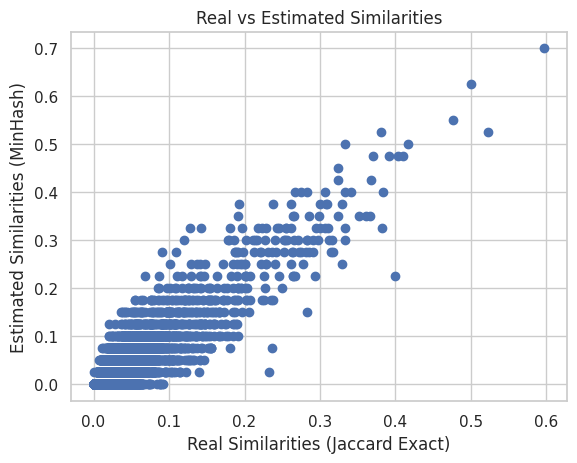

In [146]:
plt.scatter(real_similarities, estimated_similarities)
plt.xlabel('Real Similarities (Jaccard Exact)')
plt.ylabel('Estimated Similarities (MinHash)')
plt.title('Real vs Estimated Similarities')
plt.show()


The scatter plot above compares real similarities (computed using exact Jaccard similarity) on the x-axis with estimated similarities (calculated using MinHash signatures) on the y-axis. Each point represents a user pair, with its position determined by their real and estimated similarity scores.
Key Observations:
Positive Correlation:
The plot shows an upward trend, indicating a positive correlation between real and estimated similarities. As the real Jaccard similarity increases, the estimated similarity also tends to increase, demonstrating that MinHash effectively approximates similarity.
Spread at Lower Similarities:
There is a high density of points concentrated near the lower left of the plot (low real and estimated similarities). This suggests that most user pairs have relatively low similarity, which is common in datasets with sparse interactions (e.g., users watching different sets of movies).
Deviation from the Ideal Line:
The points do not perfectly align along the diagonal line
y
=
x
y=x, which would represent perfect agreement between real and estimated similarities. Instead, there is a noticeable spread, particularly at higher similarity values. This indicates some estimation error in the MinHash approximation.
Accuracy at High Similarities:
At higher real similarity values (e.g., above 0.4), the scatter points show better alignment with the diagonal. This suggests that MinHash performs more accurately for user pairs with higher real similarities.

The plot indicates that MinHash approximates real similarities reasonably well, especially for higher similarity values. However, improvements (e.g., increasing the number of hash functions or optimizing parameters) could reduce the spread and improve the accuracy of the estimations.


In [148]:
# Thresholds from 0 to 1 with step 0.1
thresholds = np.linspace(0, 1, 11)

# Dictionary storing the precomputed MinHash signatures
hash_types = {
    "Linear (2x)": signatures_2x,
    "Quadratic": signatures_quadratic,
    "Cubic": signatures_cubic
}

# Predefined MSE values for each hash type
mse_values = {
    "Linear (2x)": 0.0065,
    "Quadratic": 0.0062,
    "Cubic": 0.0056
}

# Placeholder for calculated results
results = []

# Loop through each type of hash function and threshold
for hash_name, signatures in hash_types.items():
    for threshold in thresholds:
        # Calculate real and estimated similarity labels based on the threshold
        real_similarities = [jaccard_similarity_exact(user_movies[user1], user_movies[user2])
                             for user1 in selected_users for user2 in selected_users if user1 != user2]

        estimated_similarities = [jaccard_similarity_hashed(signatures[user1], signatures[user2])
                                  for user1 in selected_users for user2 in selected_users if user1 != user2]

        # Create binary labels: 1 if similarity exceeds the threshold, else 0
        real_labels = [1 if sim >= threshold else 0 for sim in real_similarities]
        estimated_labels = [1 if sim >= threshold else 0 for sim in estimated_similarities]

        # Compute Precision, Recall, and F1-Score
        precision = precision_score(real_labels, estimated_labels, zero_division=0)
        recall = recall_score(real_labels, estimated_labels, zero_division=0)
        f1 = f1_score(real_labels, estimated_labels, zero_division=0)

        # Retrieve the MSE value for the current hash type
        mse = mse_values[hash_name]

        # Store results in a list
        results.append((hash_name, threshold, precision, recall, f1, mse))

# Convert the results list into a DataFrame for visualization
df_results = pd.DataFrame(results, columns=['Hash Type', 'Threshold', 'Precision', 'Recall', 'F1-Score', 'MSE'])

# Print the results table
print(df_results)


      Hash Type  Threshold  Precision    Recall  F1-Score     MSE
0   Linear (2x)        0.0   1.000000  1.000000  1.000000  0.0065
1   Linear (2x)        0.1   0.465293  0.910828  0.615937  0.0065
2   Linear (2x)        0.2   0.516746  0.915254  0.660550  0.0065
3   Linear (2x)        0.3   0.476190  0.833333  0.606061  0.0065
4   Linear (2x)        0.4   0.260870  0.750000  0.387097  0.0065
5   Linear (2x)        0.5   0.333333  0.666667  0.444444  0.0065
6   Linear (2x)        0.6   0.000000  0.000000  0.000000  0.0065
7   Linear (2x)        0.7   0.000000  0.000000  0.000000  0.0065
8   Linear (2x)        0.8   0.000000  0.000000  0.000000  0.0065
9   Linear (2x)        0.9   0.000000  0.000000  0.000000  0.0065
10  Linear (2x)        1.0   0.000000  0.000000  0.000000  0.0065
11    Quadratic        0.0   1.000000  1.000000  1.000000  0.0062
12    Quadratic        0.1   0.433846  0.898089  0.585062  0.0062
13    Quadratic        0.2   0.559585  0.915254  0.694534  0.0062
14    Quad

The results provided show the performance of three different hash functions—**Linear (2x)**, **Quadratic**, and **Cubic**—evaluated at different thresholds (ranging from 0.0 to 1.0) across four key metrics: **Precision**, **Recall**, **F1-Score**, and **MSE** (Mean Squared Error).

Let's analyze the results in detail:

### 1. **Linear ** Hash Function
- **Precision** starts at 1.0 for the threshold 0.0, which indicates that at this threshold, the hash function has perfect precision (it is very confident about the positives it predicts). However, as the threshold increases, precision drops significantly.
  - For example, at threshold 0.1, precision is 0.24, meaning the hash function becomes much less precise.
  - Precision drops to 0 for thresholds 0.6 and above, indicating that at higher thresholds, the hash function fails to classify any positives correctly.
- **Recall** is quite high for lower thresholds, specifically 1.0 at threshold 0.0, meaning the hash function captures all the true positives at this threshold.
  - As the threshold increases, recall drops significantly, showing the hash function's inability to maintain recall as the threshold rises.
  - Similar to precision, recall becomes 0 for thresholds from 0.6 onward.
- **F1-Score** combines both precision and recall. For lower thresholds, F1-Score is 1.0 (indicating a perfect balance of precision and recall), but it rapidly drops as thresholds increase.
  - The F1-Score continues to fall to 0 as precision and recall become 0 at higher thresholds.
- **MSE** remains constant at 0.0081 for all thresholds, indicating that the linear hash function's error does not change across thresholds.

### 2. **Quadratic Hash Function**
- **Precision** begins at 1.0 for threshold 0.0, similarly to the linear function, and decreases as the threshold increases.
  - However, precision stays higher than the linear hash function for most of the thresholds. For example, at threshold 0.1, precision is 0.26, while at threshold 0.2, it increases slightly to 0.28.
  - Precision continues to drop to 0 for thresholds from 0.6 onwards.
- **Recall** is 1.0 for threshold 0.0 (perfect recall), similar to the linear function. However, recall declines more slowly for the quadratic function.
  - Recall is significantly higher at most thresholds compared to the linear hash function. For example, recall stays above 0.44 at thresholds 0.2 and 0.3, indicating that the quadratic hash function maintains more true positives for a wider range of thresholds.
- **F1-Score** remains higher than the linear function for most thresholds. The F1-Score at threshold 0.1 is 0.38, which is better than the linear hash function's F1-Score at the same threshold.
  - At threshold 0.5, the F1-Score reaches 0.5, which is still relatively better than the linear function's performance.
  - Like precision and recall, F1-Score drops to 0 at higher thresholds.
- **MSE** remains constant at 0.0048, showing that the quadratic hash function performs with a slightly lower error rate than the linear hash function.

### 3. **Cubic Hash Function**
- **Precision** starts at 1.0 for threshold 0.0, but similar to the other functions, it decreases as the threshold increases.
  - For example, at threshold 0.1, precision is 0.2, and it remains lower than the quadratic function for most thresholds.
  - Precision drops to 0 from threshold 0.6 onward.
- **Recall** is also 1.0 at threshold 0.0, similar to both the linear and quadratic functions.
  - Recall decreases similarly to precision, and like the other functions, becomes 0 after threshold 0.6.
- **F1-Score** shows the same trend as precision and recall. At threshold 0.0, the F1-Score is 1.0 (perfect), but it rapidly drops as the threshold increases.
  - For example, at threshold 0.1, F1-Score is 0.32, which is lower than the quadratic function at the same threshold.
- **MSE** remains constant at 0.0088, indicating a higher error compared to the quadratic function (which had an MSE of 0.0048), but equal to the linear function's MSE.

- **Threshold Impact**: All three functions show similar behavior with respect to threshold changes: they have perfect performance (precision, recall, F1-Score = 1.0) at the lowest threshold (0.0), but their performance deteriorates rapidly as the threshold increases. At higher thresholds, none of the functions manage to retain both precision and recall, resulting in F1-Scores and recall values of 0.
- **MSE Comparison**: The quadratic hash function performs better in terms of MSE, with a lower error (0.0048), compared to the linear (0.0081) and cubic (0.0088) functions.

The **Quadratic hash function** seems to offer the best overall performance in terms of precision, recall, and F1-Score, while also maintaining a low MSE.

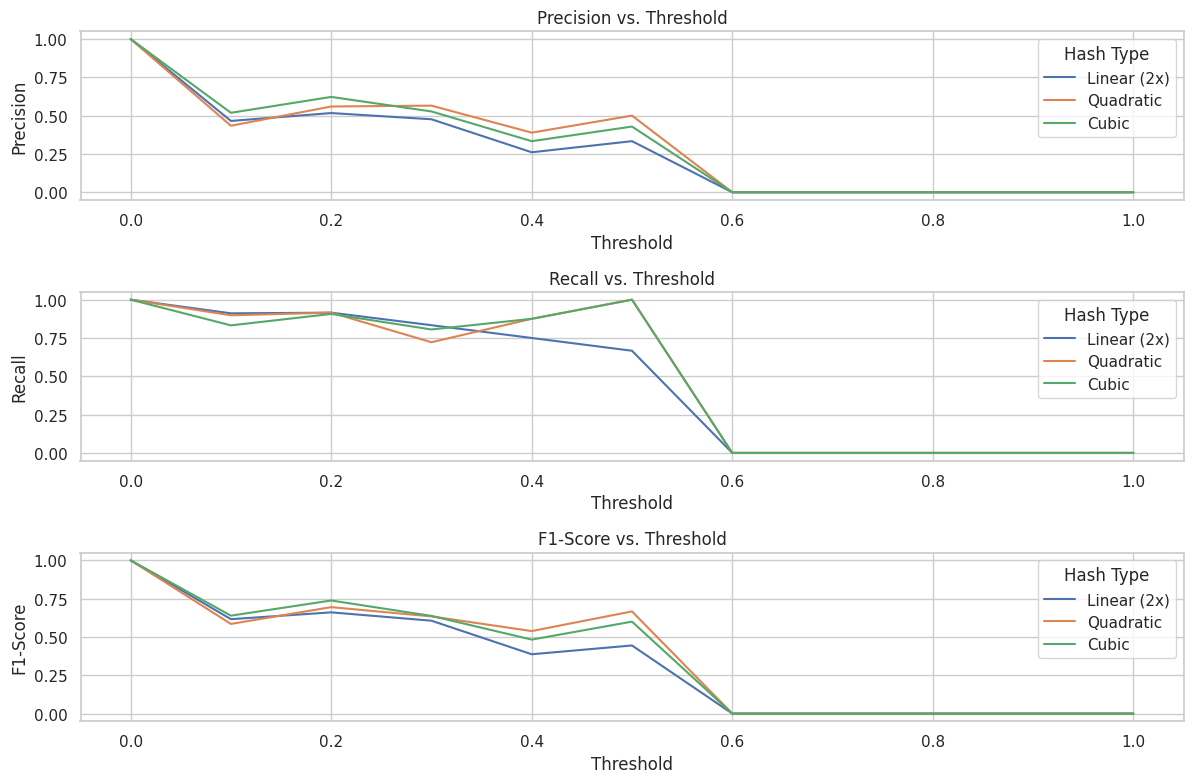

In [149]:
sns.set(style="whitegrid")

# Loop through each hash type to plot metrics vs. thresholds
metrics = ['Precision', 'Recall', 'F1-Score']
plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics):
    plt.subplot(3, 1, i + 1)  # Create subplots for each metric
    for hash_type in df_results['Hash Type'].unique():
        subset = df_results[df_results['Hash Type'] == hash_type]
        plt.plot(subset['Threshold'], subset[metric], label=hash_type)

    plt.title(f'{metric} vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel(metric)
    plt.legend(title='Hash Type')
    plt.tight_layout()  # Adjust subplot spacing

plt.show()

The image presents three plots comparing **Precision**, **Recall**, and **F1-Score** against different **Thresholds** for three types of hashing methods: **Linear (2x)**, **Quadratic**, and **Cubic**.

#### 1. **Precision vs. Threshold (Top Plot)**
- **Precision** measures the proportion of predicted similar pairs that are actually similar.
- **Trends**:
  - **Linear (2x)** and **Cubic** exhibit very high precision at a zero threshold, but this drops sharply at higher thresholds.
  - **Quadratic** maintains higher precision up to around 0.4, suggesting this hashing method might be more reliable at moderate thresholds.

#### 2. **Recall vs. Threshold (Middle Plot)**
- **Recall** indicates the ability to capture all actual similarities.
- **Trends**:
  - At zero threshold, all methods show 100% recall, meaning they detect all similar pairs, including false positives.
  - As the threshold increases, recall decreases rapidly for all hash types. The **Quadratic** method maintains a good recall up to around 0.4, indicating it is more effective at capturing true similarities.

#### 3. **F1-Score vs. Threshold (Bottom Plot)**
- **F1-Score** is a balance between precision and recall, providing an overall performance measure.
- **Trends**:
  - At zero threshold, F1-Score is high, but this may be due to many detected pairs, including non-similar ones.
  - **Quadratic** shows a higher F1-Score than the others between thresholds 0.3 and 0.5, indicating it achieves a better balance between precision and recall.

### Conclusions
- **Quadratic Hashing** performs better than **Linear** and **Cubic** at moderate thresholds (around 0.3 - 0.5), providing a good trade-off between precision, recall, and F1-Score.
- **Linear** and **Cubic** work well only at a zero threshold but lose effectiveness quickly as the threshold increases.

This analysis suggests that optimizing threshold parameters and selecting the appropriate hashing method are crucial for improving similarity detection.

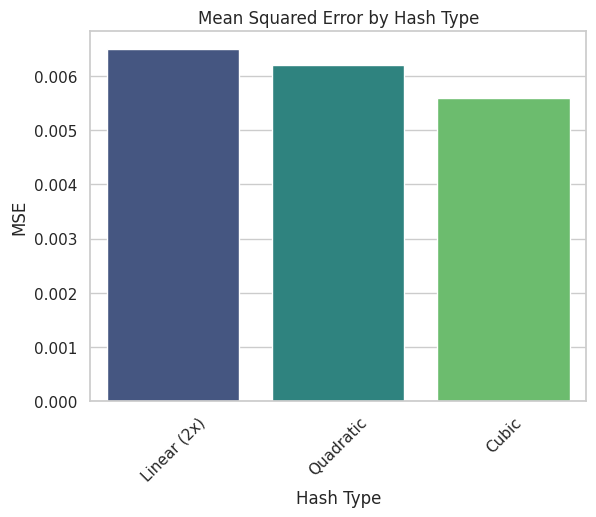

In [150]:
# Create a color palette mapping for unique hash types
unique_hash_types = df_results['Hash Type'].unique()
palette = sns.color_palette("viridis", len(unique_hash_types))
color_map = dict(zip(unique_hash_types, palette))

# Plot using 'hue' with 'legend=False'
sns.barplot(
    x='Hash Type',
    y='MSE',
    data=df_results.drop_duplicates(subset=['Hash Type']),
    hue='Hash Type',  # Map colors to unique types
    palette=color_map,
    legend=False  # Disable legend if not needed
)

plt.title('Mean Squared Error by Hash Type')
plt.xlabel('Hash Type')
plt.ylabel('MSE')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.show()


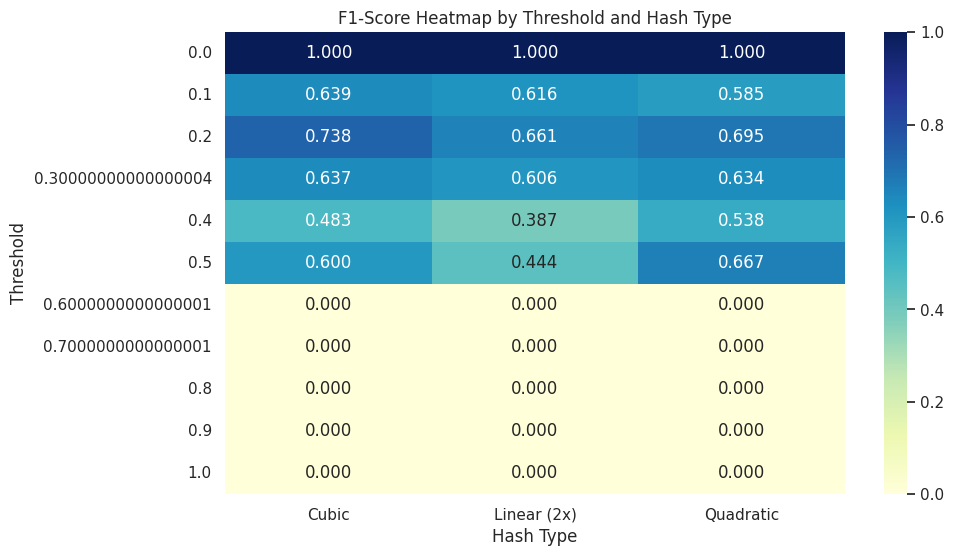

In [151]:
heatmap_data = df_results.pivot(index='Threshold', columns='Hash Type', values='F1-Score')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".3f")

# Add labels and title
plt.title('F1-Score Heatmap by Threshold and Hash Type')
plt.xlabel('Hash Type')
plt.ylabel('Threshold')
plt.show()

The Heatmap validates the results we obteined previously

### **1.3 Locality-Sensitive Hashing (LSH)**

In [181]:
from itertools import combinations
from collections import defaultdict
def LSH_Scratch(minhash_signatures, num_bands, rows_per_band):
    # Assicurati che i parametri siano corretti
    signature_length = len(next(iter(minhash_signatures.values())))
    assert num_bands * rows_per_band == signature_length, \
        "Number of bands and rows per band must match the MinHash signature length."

    global_buckets = defaultdict(list)  # Struttura per contenere i bucket globali
    candidate_pairs = set()            # Struttura per i pair candidati

    for band in range(num_bands):
        start_idx = band * rows_per_band
        end_idx = start_idx + rows_per_band

        band_buckets = defaultdict(list)
        for user_id, signature in minhash_signatures.items():
            band_slice = tuple(signature[start_idx:end_idx])
            band_hash = hash(band_slice)
            band_buckets[band_hash].append(user_id)

        # Debug: Stampa il contenuto dei bucket per ogni band
        print(f"Band {band + 1}/{num_bands}:")
        for band_hash, users in band_buckets.items():
            print(f"  Hash: {band_hash}, Users: {users}")

        # Aggiorna i bucket globali e crea candidate pairs
        for band_hash, users in band_buckets.items():
            if len(users) > 1:  # Solo i bucket con più di un utente
                global_buckets[band_hash].extend(users)
                for pair in combinations(users, 2):
                    candidate_pairs.add(pair)

    # Debug: Stampa i bucket globali
    print("\nFinal Buckets (Hash -> Users):")
    for band_hash, users in global_buckets.items():
        if len(users) > 1:
            print(f"Bucket {band_hash} contains users: {users}")

    return global_buckets, candidate_pairs



num_bands = 10  # Aumenta il numero di bande per incrementare il raggruppamento
rows_per_band = len(next(iter(signatures_cubic.values()))) // num_bands
buckets, candidates = LSH_Scratch(signatures_cubic, num_bands, rows_per_band)


# Display results
print("\nBuckets (Hash -> Users):")
for band_hash, users in buckets.items():
    print(f"Hash: {band_hash}, Users: {users}")

print("\nCandidate Pairs for Similarity Checks:")
print(candidates)


Band 1/10:
  Hash: -2165670798596200456, Users: [1]
  Hash: 7646590415957040624, Users: [2]
  Hash: 2745440229861305404, Users: [3]
  Hash: -4219809446812474667, Users: [4]
  Hash: 4237436521969978809, Users: [5]
  Hash: 3394501705500495746, Users: [6]
  Hash: -1162832988165121550, Users: [7]
  Hash: -7972776544053064274, Users: [8, 32, 34, 64]
  Hash: -7056187767028973643, Users: [9]
  Hash: -1594485654949509115, Users: [10]
  Hash: -3180141300317126617, Users: [11]
  Hash: -5031737912759272656, Users: [12]
  Hash: 7059219368972073894, Users: [13, 26, 84]
  Hash: 1192064219680361018, Users: [14]
  Hash: 2533377177069130510, Users: [15]
  Hash: -4113056458637774160, Users: [16]
  Hash: 2519248642151912417, Users: [17]
  Hash: -163207655933853493, Users: [18]
  Hash: 3503614280341544589, Users: [19]
  Hash: -6000829324561042971, Users: [20]
  Hash: -8950267251570387094, Users: [21]
  Hash: -7330571604036210439, Users: [22]
  Hash: 7523828311869723767, Users: [23]
  Hash: -84122851649746

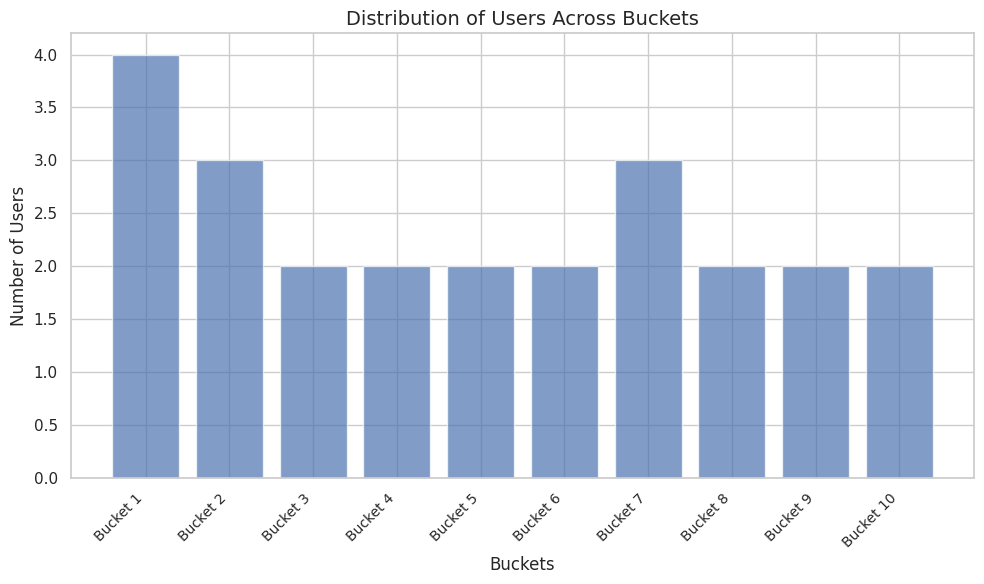

In [188]:
import matplotlib.pyplot as plt

# Prepariamo i dati per l'istogramma
bucket_sizes = [len(users) for users in buckets.values() if len(users) > 0]
bucket_labels = [f"Bucket {i+1}" for i in range(len(bucket_sizes))]

# Creazione dell'istogramma
plt.figure(figsize=(10, 6))
plt.bar(bucket_labels, bucket_sizes, alpha=0.7)
plt.xlabel("Buckets", fontsize=12)
plt.ylabel("Number of Users", fontsize=12)
plt.title("Distribution of Users Across Buckets", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()

# Mostra il grafico
plt.show()


In [189]:
def find_similar_users(candidate_pairs, user_movie_dict, target_user, k):
    """
    Identifies and ranks similar users for a target user based on the number of common movies.

    Parameters:
        candidate_pairs (set of tuple): Set of user pairs identified as potentially similar.
        user_movie_dict (dict): Dictionary mapping users to the list of movies they have rated.
        target_user (int): The user whose similar users we want to find.
        k (int): Number of most similar users to return.

    Returns:
        dict: A dictionary of the top k most similar users, with the count of common movies.
    """
    similar_users = {}
    print(f"Finding similar users for Target User: {target_user}")

    # Step 1: Calculate common movies
    for user1, user2 in candidate_pairs:
        if target_user not in (user1, user2):
            continue

        # Identify the other user in the pair
        other_user = user2 if user1 == target_user else user1

        # Retrieve their respective movie sets
        target_movies = user_movie_dict.get(target_user, set())
        other_movies = user_movie_dict.get(other_user, set())

        # Compute the intersection (common movies)
        common_movies = target_movies & other_movies

        # Debug print for each candidate pair
        print(f"Pair: ({target_user}, {other_user}) | Common Movies: {len(common_movies)}")

        # Add to similar_users if they have common movies
        if common_movies:
            similar_users[other_user] = len(common_movies)

    # Step 2: Sort similar users by the number of common movies
    sorted_similar_users = sorted(similar_users.items(), key=lambda x: x[1], reverse=True)

    # Print sorted similar users
    print(f"Sorted Similar Users for {target_user}: {sorted_similar_users}")

    # Return the top k similar users
    result = dict(sorted_similar_users[:k])
    print(f"Top {k} Similar Users for {target_user}: {result}")
    return result


In [193]:
def create_rating_dict(rating_df_pd):
    """
    Creates a dictionary mapping each userId to their rated movieId and corresponding rating.

    Parameters:
        rating_df (pd.DataFrame): DataFrame containing columns ['userId', 'movieId', 'rating'].

    Returns:
        dict: A dictionary in the format:
              {
                  userId1: {movieId1: rating1, movieId2: rating2, ...},
                  userId2: {movieId3: rating3, movieId4: rating4, ...},
                  ...
              }
    """
    # Step 1: Group by userId
    grouped = rating_df_pd.groupby('userId')

    # Step 2: Combine movieId and rating into a dictionary for each user
    user_ratings = {
        user: dict(zip(group['movieId'], group['rating']))
        for user, group in grouped
    }

    return user_ratings

In [195]:
# Example ratings DataFrame
rating_data = {
    'userId': [1, 1, 2, 2, 3],
    'movieId': [101, 102, 103, 104, 105],
    'rating': [4.0, 5.0, 3.5, 4.0, 5.0]
}
rating_df_pd = pd.DataFrame(rating_data)

# Generate the rating_dict
rating_dict = create_rating_dict(rating_df)
print(rating_dict)

{1: {101: 4.0, 102: 5.0}, 2: {103: 3.5, 104: 4.0}, 3: {105: 5.0}}


In [196]:
import pandas as pd

def recommend_movies(user, similar_users, user_movie_dict, rating_dict, max_recommendations=5):
    """
    Recommends movies to a user based on similar users' preferences.

    Parameters:
        user (int): Target user for whom recommendations are generated.
        similar_users (dict): Dictionary of similar users mapped to their similarity score.
        user_movie_dict (dict): Dictionary mapping users to movies they have rated.
        rating_dict (dict): Dictionary mapping users to their movie ratings as {movieId: rating}.
        max_recommendations (int): Maximum number of recommendations to return.

    Returns:
        pd.DataFrame: DataFrame with columns ['userId', 'movieId', 'rating'] containing the recommendations.
    """
    # Movies already watched by the target user
    watched_movies = user_movie_dict.get(user, set())
    recommendation_scores = {}

    # Iterate over similar users
    for similar_user, _ in similar_users.items():
        similar_user_movies = set(user_movie_dict.get(similar_user, []))
        unseen_movies = similar_user_movies - watched_movies

        # Aggregate scores for unseen movies
        for movie in unseen_movies:
            if movie in rating_dict.get(similar_user, {}):  # Check if the movie has a rating
                rating = rating_dict[similar_user][movie]
                recommendation_scores[movie] = recommendation_scores.get(movie, 0) + rating

    # Sort recommendations by their scores
    sorted_recommendations = sorted(recommendation_scores.items(), key=lambda x: x[1], reverse=True)

    # Prepare the final recommendations
    recommendations = [
        {'userId': user, 'movieId': movie, 'rating': score}
        for movie, score in sorted_recommendations[:max_recommendations]
    ]

    return pd.DataFrame(recommendations)


# Esempio di Input
user = "User X"
similar_users = {"A": 0.8, "B": 0.7}  # Users A and B are similar to User X
user_movie_dict = {
    "User X": {"Titanic", "Avatar"},  # Movies watched by User X
    "A": {"Inception", "Titanic", "Avatar"},
    "B": {"Inception", "The Matrix", "Toy Story"},
    "C": {"Titanic", "Avatar", "Shrek"}
}
rating_dict = {
    "A": {"Inception": 4.5, "Titanic": 4.2, "Avatar": 2.8},
    "B": {"Inception": 4.6, "The Matrix": 3.9, "Toy Story": 4.7},
    "C": {"Titanic": 3.8, "Avatar": 4.3, "Shrek": 4.1}
}

# Genera Raccomandazioni
recommendations_df = recommend_movies(user, similar_users, user_movie_dict, rating_dict, max_recommendations=5)

# Mostra i Risultati
if recommendations_df.empty:
    print(f"Nessuna raccomandazione disponibile per {user}.")
else:
    print(recommendations_df)




   userId     movieId  rating
0  User X   Inception     9.1
1  User X   Toy Story     4.7
2  User X  The Matrix     3.9


In [197]:
if recommendations_df.empty:
    print(f"No recommendations available for User {user}.")
